In [25]:
import torch
from torch.utils import data
from torch import nn
import sklearn.datasets
import time
import matplotlib.pyplot as plt
import numpy as np
import wandb
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

In [27]:
class TwoMoonsClassification:
    def forward(self, X, params):
        res1 = torch.mm(X, params[0])
        res2 = torch.where(res1 < 0, torch.tensor(0, dtype=torch.float32, requires_grad=True), res1)
        res3 = torch.sum(torch.mm(res2, params[1]), 1)
        return res3

    def sigmoid(self, out):
        return 1 / (1 + torch.exp(-out))

    def loss(self, x, params, y):
        return -torch.dot(
            y, torch.log(self.sigmoid(self.forward(x, params)))
        ) - torch.dot(1 - y, torch.log(1 - self.sigmoid(self.forward(x, params))))

    def lossval(self, x, params, y):
        return (
            -torch.dot(y, torch.log(self.sigmoid(self.forward(x, params))))
            - torch.dot(1 - y, torch.log(1 - self.sigmoid(self.forward(x, params))))
        ) / len(x)

    def quantization(self, params):
        paramsb=[]
        for param in params:
            paramsb.append(((param > 0).float() - 0.5) * 2)
        return paramsb

In [28]:
def sgd(params, eps, alpha, step_size, batch_size):
    with torch.no_grad():
        for param in params:
            param -= step_size * param.grad / batch_size
            param.grad.zero_()

In [29]:
def speed(w, eps, alpha, sg, M):
    with torch.no_grad():
        psi = eps - (w**2 - 1) ** 2
        psid = -4 * (w**2 - 1) * w
        sp = torch.where(
            torch.logical_or(psi > 0, (-psid * sg) >= -alpha * psi),
            -sg,
            torch.clip(-alpha * psi / psid, -M, M),
        )
    return sp

def askewsgd(params, eps, alpha, step_size, batch_size):
    with torch.no_grad():
        for param in params:
            sg = param.grad / batch_size
            param += step_size * speed(param, eps, alpha, sg, 1)
            param.grad.zero_()

In [30]:
def newspeed(w, eps, alpha, sg, M):
    with torch.no_grad():
        psi = eps - (1 - w**2)
        psid = 2 * w
        sp = torch.where(
            torch.logical_or(psi > 0, (-psid * sg) >= -alpha * psi),
            -sg,
            torch.clip(-alpha * psi / psid, -M, M),
        )
    return sp
def newaskewsgd(params, eps, alpha, step_size, batch_size):
    with torch.no_grad():
        for param in params:
            sg = param.grad / batch_size
            param += step_size * newspeed(param, eps, alpha, sg, 1)
            param.grad.zero_()

In [31]:
def hard_sigmoid(w):
    return torch.clip((w + 1) / 2, 0, 1)
def bcsgd(params, eps, alpha, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            torch.clip(param, -1, 1)
            param.grad.zero_()

In [32]:
def qste(w):
    return torch.where(torch.logical_or(w>1, w<-1) == True, 0, 1)
def ste(params, eps, alpha, lr, batch_size):
    with torch.no_grad():
        for param in params:
            d = qste(param)
            param -= lr * d * param.grad / batch_size
            param.grad.zero_()

In [33]:
def load_array(features, labels, batch_size, is_train=True):
    dataset = data.TensorDataset(features, labels)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [34]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [35]:
class ModelTrainerExperiment1:
    def __init__(self, n_train, n_test, w_hidden):
        # activate CUDA
        device = "cuda" if torch.cuda.is_available() else "cpu"
        # generate data
        self.n_train = n_train
        self.n_test = n_test
        self.n = n_train + n_test
        self.X, self.Y = sklearn.datasets.make_moons(
            n_samples=self.n, noise=0.1, random_state=0
        )
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float().reshape(-1)
        self.X_train, self.Y_train = self.X[:n_train], self.Y[:n_train]
        self.X_test, self.Y_test = self.X[n_train:], self.Y[n_train:]
        W1 = torch.normal(mean=torch.zeros(2, w_hidden), std=0.1).requires_grad_()
        W2 = torch.normal(mean=torch.zeros(w_hidden, 1), std=0.1).requires_grad_()
        self.params = [W1, W2]

    def train(
        self,
        ax,
        optimizer,
        batch_size,
        num_epoch,
        decay_epochs,
        k=0.88,
        alpha=0,
        lr=0,
        lr_decay=1,
    ):
        net = TwoMoonsClassification()
        params = []
        for param in self.params:
            params.append(param.clone().detach())
            params[-1].requires_grad_()
        l=TwoMoonsClassification.loss(net, self.X, params, self.Y)
        l.backward()
        loss = []
        quantized_loss = []
        data_iter = load_array(self.X_train, self.Y_train, batch_size)
        opti = optimizer
        for epoch in range(num_epoch):
            if epoch < 50:
                eps = 1
            else:
                eps = k ** (epoch - 50)
            if epoch in decay_epochs:
                lr *= lr_decay
            for X, y in data_iter:
                if optimizer == bcsgd or optimizer == ste:
                    with torch.no_grad():
                        paramsb = net.quantization(params)
                        for param in paramsb:
                            param.requires_grad_()
                    l = net.loss(X, paramsb, y)
                    l.backward()
                    for i in range(len(paramsb)):
                        params[i].grad = paramsb[i].grad
                else:
                    l = net.loss(X, params, y)
                    l.backward()
                opti(params, eps, alpha, lr, len(X))
                with torch.no_grad():
                    loss.append(
                        net.lossval(X, params, y)
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    quantized_loss.append(
                        net.lossval(
                            X,
                            net.quantization(params),
                            y,
                        )
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    if optimizer == askewsgd or optimizer == bcsgd or optimizer == ste:
                        for param in params:
                            param.data.clamp_(-1, 1)
                wandb.log(
                    {
                        "loss": loss[-1],
                        "quantized_loss": quantized_loss[-1]
                    }
                )
        ax.set_xlabel(r"Iterations", fontsize=16)
        ax.set_ylabel(r"loss", fontsize=16)
        ax.plot(loss)
        return loss, quantized_loss

loss,█▃▃▃▂▅▃▂▄▁▂▃▄▁▃▂▃▄▂▃▃▃▃▂▂▃▂▃▂▂▂▂▂▃▃▂▄▁▃▄
quantized_loss,▆▃▆▃▂█▅▃█▂▃▅▆▁▆▃▅▆▂▅▄▅▅▂▃▄▂▄▃▃▃▂▃▄▃▃▇▂▅▇
loss,0.33812
quantized_loss,0.37853


loss,█▅▃▄▄▅▂▃▃▃▁▃▄▂▄▃▃▂▂▃▄▃▂▃▂▂▃▂▂▃▂▂▂▄▁▂▂▄▂▃
quantized_loss,▄▆▂▇▄█▁▄▃▄▁▃▃▂▄▅▆▁▂▄▅▅▃▄▄▅▄▂▅▄▄▂▃▄▃▃▃▇▃▅
loss,0.25194
quantized_loss,0.44868


loss,█▃▃▃▃▂▃▃▂▄▄▃▃▂▃▃▃▃▂▃▂▃▃▃▃▃▄▃▄▃▃▃▃▁▂▄▃▂▃▁
quantized_loss,▇▃▃▄▅▄▆▅▅█▇▇▆▆▄▅▆█▆▆▅▅█▆▅▆▇▆▅▄▇▇▄▁▂▆▇▇▆▁
loss,0.19699
quantized_loss,0.42897


loss,█▅▃▂▃▂▂▂▃▂▂▃▃▁▁▂▂▂▃▁▃▁▃▂▃▂▂▂▂▃▂▁▃▂▃▃▃▃▃▂
quantized_loss,▆▃▄▃▅▄▄▃▅▂▃▆▇▁▁▃▅▃▆▂▄▂▅▃▄▅▆▃▄▇▃▂▆▄▃▄█▆▅▂
loss,0.33722
quantized_loss,0.39119


loss,█▅▄▃▃▃▂▂▂▂▃▃▃▂▃▂▃▃▂▂▂▃▂▃▂▂▁▂▂▂▂▃▃▂▁▂▃▃▃▃
quantized_loss,▆▄▇▄▆▆▅▃▃▂▆▄▄▂▇▃▃▆▅▄▄▅▃▅▃▅▁█▄▅▂█▅▃▆▃▄▆▆▄
loss,0.33721
quantized_loss,0.34179


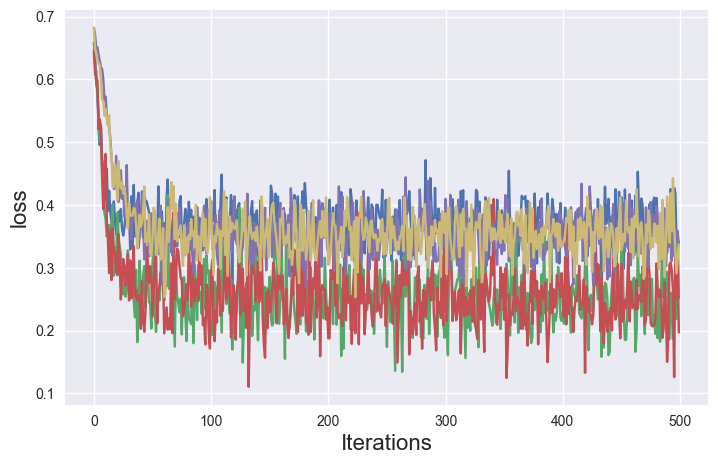

In [36]:
trainer = ModelTrainerExperiment1(n_train=2000, n_test=200, w_hidden=3)
num_epoch = 25
batch_size = 100
decay_epoch = [30, 60]
# Using seaborn's style
plt.style.use("seaborn")
width = 600
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2",
    name="ASkewSGD_0.5",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "ASkewSGD_0.5",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
# simulate training

ModelTrainerExperiment1.train(
    trainer, ax, askewsgd, batch_size=batch_size, num_epoch=num_epoch, decay_epochs=decay_epoch, alpha=4, lr=1, lr_decay=0.5
)
wandb.finish()
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2",
    name="newASkewSGD_0.5",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "ASkewSGD_0.5",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
# simulate training

ModelTrainerExperiment1.train(
    trainer, ax, newaskewsgd, batch_size=batch_size, num_epoch=num_epoch, decay_epochs=decay_epoch, alpha=4, lr=1, lr_decay=0.5
)
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2",
    name="SGD",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "SGD",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
ModelTrainerExperiment1.train(trainer, ax, sgd, batch_size=batch_size, decay_epochs=decay_epoch, num_epoch=num_epoch, lr=1, lr_decay=0.5)
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2",
    name="BinaryConnect",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "BinaryConnect",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
ModelTrainerExperiment1.train(trainer, ax, bcsgd, batch_size=batch_size, decay_epochs=decay_epoch, num_epoch=num_epoch, lr=1, lr_decay=0.5)
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="exp2",
    name="STE",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "StraightThroughEstimator",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
ModelTrainerExperiment1.train(trainer, ax, ste, batch_size=batch_size, num_epoch=num_epoch, decay_epochs=decay_epoch, lr=1, lr_decay=0.5)
wandb.finish()
fig.savefig("loss_twomoonsregression.pdf", format="pdf", bbox_inches="tight")